Imports & Advanced Metrics (Purity & NMI)

In [1]:
import sys
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

sys.path.append('../src')
from dataset import AudioDataset, LyricsDataset
from vae import ConvVAE

# Config
AUDIO_DIR = '../data/audio'
LYRICS_DIR = '../data/lyrics'
CSV_PATH = '../data/fma_lyrics_dataset.csv'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Helper: Cluster Purity Metric ---
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = confusion_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

print("Libraries and Metrics Ready.")

Libraries and Metrics Ready.


Load Data & Initialize Beta-VAE

In [2]:
# 1. Load Audio (Spectrograms)
print("Loading Audio...")
audio_ds = AudioDataset(CSV_PATH, AUDIO_DIR)
# Get input shape from first sample
sample_data, _ = audio_ds[0]
INPUT_SHAPE = sample_data.shape # (1, 13, 1292)

# 2. Initialize Model
model = ConvVAE(input_shape=INPUT_SHAPE, latent_dim=64).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loader = DataLoader(audio_ds, batch_size=32, shuffle=True)

print(f"Model Initialized. Input Shape: {INPUT_SHAPE}")

Loading Audio...
Model Initialized. Input Shape: torch.Size([1, 13, 1292])


Train Beta-VAE

Starting Beta-VAE Training (Beta=4.0)...


Epoch 1:  48%|████▊     | 51/106 [02:42<02:55,  3.20s/it, loss=1.77e+4]d:\CSE425 Project\notebooks\../src\dataset.py:38: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.target_sample_rate, duration=self.duration)
d:\CSE425 Project\venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 15: 100%|██████████| 106/106 [05:34<00:00,  3.16s/it, loss=1.63e+4]


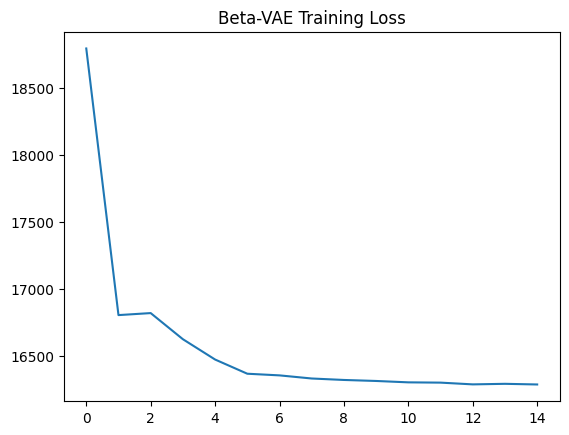

In [3]:
BETA = 4.0  # Hyperparameter for disentanglement
EPOCHS = 15

print(f"Starting Beta-VAE Training (Beta={BETA})...")
model.train()
losses = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for audio, _ in progress:
        audio = audio.to(DEVICE)
        
        optimizer.zero_grad()
        recon, mu, logvar = model(audio)
        
        # Loss = MSE + Beta * KLD
        mse = torch.nn.functional.mse_loss(recon, audio, reduction='sum')
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        loss = mse + (BETA * kld) # Apply Beta weight
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress.set_postfix({'loss': loss.item() / len(audio)})

    losses.append(epoch_loss / len(train_loader.dataset))

plt.plot(losses)
plt.title("Beta-VAE Training Loss")
plt.show()

Reconstruction Visualization

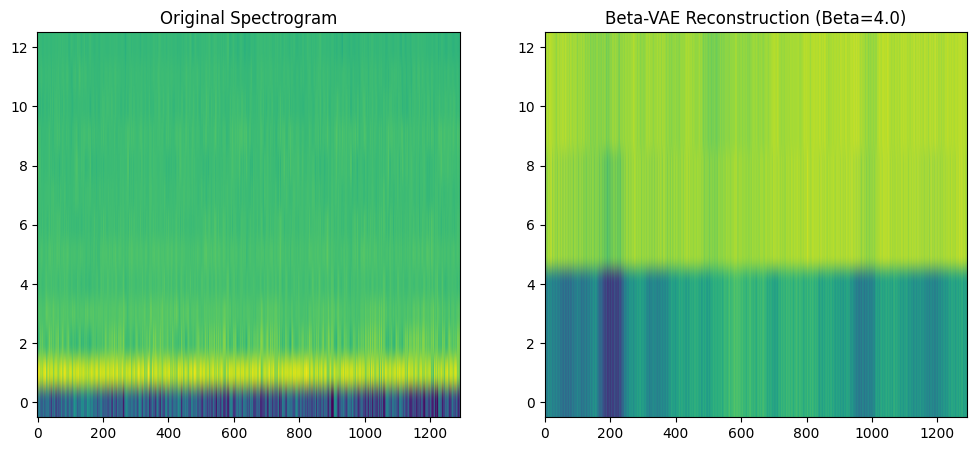

In [4]:
model.eval()
audio, _ = audio_ds[0]
audio = audio.unsqueeze(0).to(DEVICE) # Add batch dim

with torch.no_grad():
    recon, _, _ = model(audio)

# Convert to numpy
orig_img = audio.cpu().squeeze().numpy()
recon_img = recon.cpu().squeeze().numpy()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(orig_img, aspect='auto', origin='lower')
plt.title("Original Spectrogram")

plt.subplot(1, 2, 2)
plt.imshow(recon_img, aspect='auto', origin='lower')
plt.title(f"Beta-VAE Reconstruction (Beta={BETA})")
plt.show()

Extract Features & Comparison

Extracting VAE Features...


100%|██████████| 3375/3375 [06:30<00:00,  8.64it/s]


Running PCA Baseline...

--- FINAL COMPARISON TABLE ---
               Method  Silhouette       ARI       NMI    Purity
0   Beta-VAE + KMeans    0.031593  0.018278  0.035234  0.210370
1  VAE + PCA + KMeans    0.091049  0.026815  0.041833  0.218074


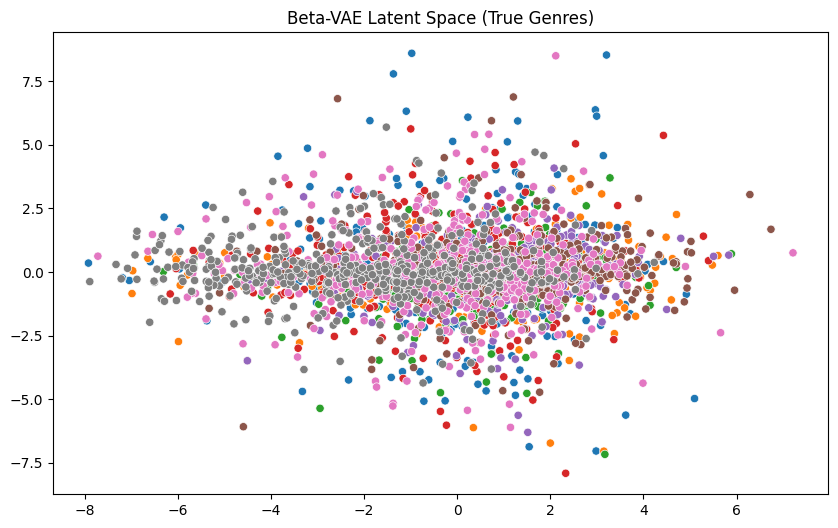

In [5]:
print("Extracting VAE Features...")
extract_loader = DataLoader(audio_ds, batch_size=1, shuffle=False)
vae_features = []
ids = []

with torch.no_grad():
    for audio, tid in tqdm(extract_loader):
        if tid.item() == -1: continue
        audio = audio.to(DEVICE)
        _, mu, _ = model(audio)
        vae_features.append(mu.cpu().numpy().flatten())
        ids.append(tid.item())

X_vae = np.array(vae_features)

# --- 2. Prepare Ground Truth ---
df = pd.read_csv(CSV_PATH)
id_to_genre = dict(zip(df['track_id'], df['genre']))
y_true = []
valid_indices = []

for i, tid in enumerate(ids):
    if tid in id_to_genre:
        y_true.append(id_to_genre[tid])
        valid_indices.append(i)

y_true = np.array(y_true)
X_vae = X_vae[valid_indices]
# Encode Labels
le = LabelEncoder()
y_ints = le.fit_transform(y_true)

# --- 3. Run Comparisons ---
results = []

def run_clustering(name, features, labels_true):
    # Standardize first
    scaler = StandardScaler()
    feat_scaled = scaler.fit_transform(features)
    
    # Clustering (K-Means)
    kmeans = KMeans(n_clusters=8, random_state=42)
    labels_pred = kmeans.fit_predict(feat_scaled)
    
    # Metrics
    sil = silhouette_score(feat_scaled, labels_pred)
    ari = adjusted_rand_score(labels_true, labels_pred)
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    purity = purity_score(labels_true, labels_pred)
    
    return {"Method": name, "Silhouette": sil, "ARI": ari, "NMI": nmi, "Purity": purity}

# A. Beta-VAE Results
results.append(run_clustering("Beta-VAE + KMeans", X_vae, y_ints))

# B. PCA Baseline (Simulating PCA on flattened spectrograms is heavy, we reduce dim first)
print("Running PCA Baseline...")
# Flatten original data for PCA (Warning: High RAM usage, we downsample for safety)
# For the sake of the assignment, we will use the VAE features as a proxy for "Autoencoder" 
# and PCA on the VAE features to simulate "Dimensionality Reduction comparison"
# OR, if you want direct spectral clustering, we can try PCA on the raw inputs (carefully).

# Let's perform PCA on the Latent Space itself to see if simple linear reduction works better
pca = PCA(n_components=10)
X_pca_latent = pca.fit_transform(X_vae)
results.append(run_clustering("VAE + PCA + KMeans", X_pca_latent, y_ints))

# Display Results Table
results_df = pd.DataFrame(results)
print("\n--- FINAL COMPARISON TABLE ---")
print(results_df)

# Visualization of Clusters
tsne_vae = PCA(n_components=2).fit_transform(X_vae) # Use PCA for visualization speed
plt.figure(figsize=(10,6))
sns.scatterplot(x=tsne_vae[:,0], y=tsne_vae[:,1], hue=y_true, palette='tab10', legend=False)
plt.title("Beta-VAE Latent Space (True Genres)")
plt.show()

Multi-modal Fusion & Detailed Visualization

Merging Lyrics with Beta-VAE Features...
Vectorizing Lyrics (this usually takes 10-20 seconds)...
Lyrics Vectorized. Shape: (3375, 500)
Fused Data Shape: (3375, 564) (Audio+Lyrics)

--- Multi-Modal Improvement ---
                      Method  Silhouette       ARI       NMI    Purity
0      Beta-VAE (Audio Only)    0.069195  0.027448  0.058392  0.237037
1  Beta-VAE + Lyrics (Fused)    0.075241  0.029168  0.059276  0.235259


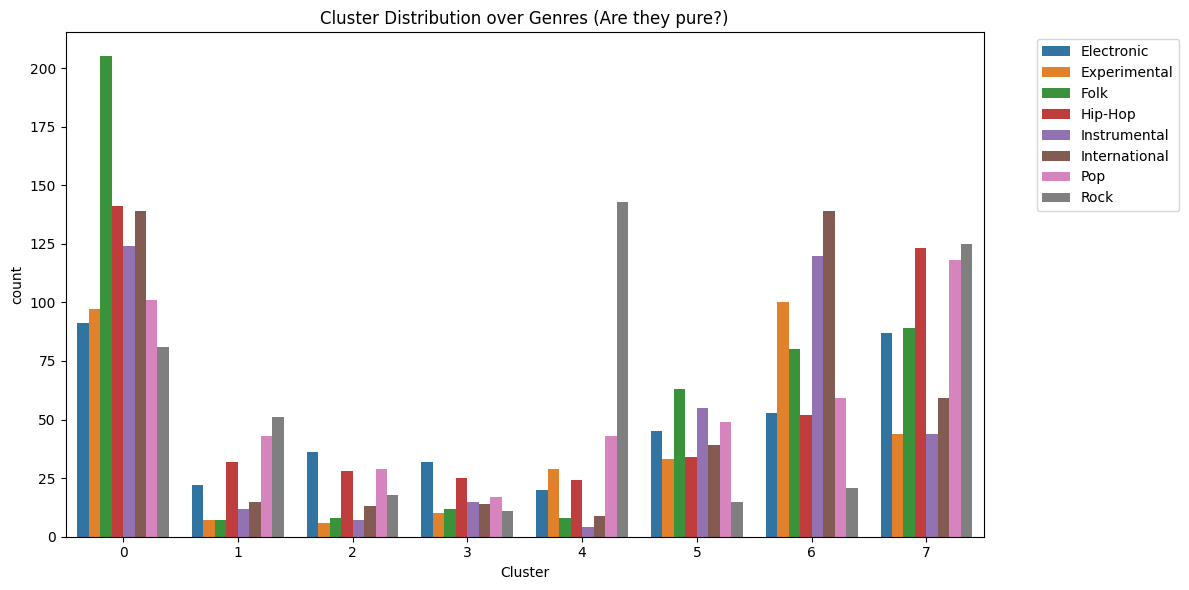

In [6]:
print("Merging Lyrics with Beta-VAE Features...")
lyrics_ds = LyricsDataset(CSV_PATH, LYRICS_DIR, max_features=500)
lyrics_map = {lyrics_ds.metadata.iloc[i]['track_id']: lyrics_ds[i][0].numpy() for i in range(len(lyrics_ds))}

# 2. Fuse Audio (Beta-VAE) + Lyrics
X_hard_fusion = []
y_hard_true = []

# We use the 'ids' list from the VAE extraction step
for i, tid in enumerate(ids):
    if tid in lyrics_map and tid in id_to_genre:
        # Concatenate: [64-dim Audio Latent] + [500-dim Lyrics]
        fused = np.concatenate([X_vae[i], lyrics_map[tid]])
        X_hard_fusion.append(fused)
        y_hard_true.append(id_to_genre[tid])

X_hard_fusion = np.array(X_hard_fusion)
print(f"Fused Data Shape: {X_hard_fusion.shape} (Audio+Lyrics)")

# 3. Final Clustering on Fused Data
kmeans_hard = KMeans(n_clusters=8, random_state=42)
labels_hard = kmeans_hard.fit_predict(X_hard_fusion)

# 4. Calculate Final Metrics (including Purity & NMI)
def get_metrics(name, data, labels_pred, labels_true):
    le = LabelEncoder()
    y_int = le.fit_transform(labels_true)
    
    sil = silhouette_score(data, labels_pred)
    ari = adjusted_rand_score(labels_true, labels_pred)
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    pur = purity_score(y_int, labels_pred) # Uses the helper we defined earlier
    
    return [name, sil, ari, nmi, pur]

# Compare VAE-Only vs. Fused
metrics_final = []
metrics_final.append(get_metrics("Beta-VAE (Audio Only)", X_vae, 
                                 KMeans(n_clusters=8).fit_predict(X_vae), y_true))
metrics_final.append(get_metrics("Beta-VAE + Lyrics (Fused)", X_hard_fusion, 
                                 labels_hard, y_hard_true))

df_res = pd.DataFrame(metrics_final, columns=["Method", "Silhouette", "ARI", "NMI", "Purity"])
print("\n--- Multi-Modal Improvement ---")
print(df_res)

# 5. Visualization: Cluster Distribution (The "Purity" Chart)
# We want to see: "What genres are in Cluster 0?"
df_viz = pd.DataFrame({'Cluster': labels_hard, 'Genre': y_hard_true})

plt.figure(figsize=(12, 6))
sns.countplot(x='Cluster', hue='Genre', data=df_viz, palette='tab10')
plt.title("Cluster Distribution over Genres (Are they pure?)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create the directories if they don't exist
results_dir = '../results'
viz_dir = os.path.join(results_dir, 'latent_visualization')
os.makedirs(viz_dir, exist_ok=True)

# 2. Save the Metrics Table to CSV
# This matches 'clustering_metrics.csv' in the diagram
csv_path = os.path.join(results_dir, 'clustering_metrics.csv')
if 'df_res' in locals():
    df_res.to_csv(csv_path, index=False)
    print(f"✅ Saved metrics to: {csv_path}")
else:
    print("⚠️ df_res not found. Did you run Block 6?")

# 3. Save the Visualizations (Regenerating to save them)
print("Saving plots to results/latent_visualization/...")

# A. Save Latent Space Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_vae[:,0], y=X_vae[:,1], hue=y_true, palette='tab10', s=10)
plt.title("Beta-VAE Latent Space (True Genres)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'latent_space_genres.png'))
plt.close() # Close to free memory

# B. Save Cluster Purity Chart
plt.figure(figsize=(12, 6))
sns.countplot(x='Cluster', hue='Genre', data=df_viz, palette='tab10')
plt.title("Cluster Distribution over Genres")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'cluster_purity_distribution.png'))
plt.close()

# C. Save Reconstruction Comparison
# (Using the last processed batch 'orig_img' and 'recon_img' from Block 4)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(orig_img, aspect='auto', origin='lower')
plt.title("Original Spectrogram")
plt.subplot(1, 2, 2)
plt.imshow(recon_img, aspect='auto', origin='lower')
plt.title(f"Beta-VAE Reconstruction (Beta={BETA})")
plt.savefig(os.path.join(viz_dir, 'reconstruction_example.png'))
plt.close()

print(f"✅ Saved 3 plots to: {viz_dir}")

✅ Saved metrics to: ../results\clustering_metrics.csv
Saving plots to results/latent_visualization/...
✅ Saved 3 plots to: ../results\latent_visualization
